# Figure with alternative posterior predictive checks of the integrated method

This figure shows:

* Timeseries of interplotated UMAPs
* Marginal distributions of the marker expression. Predicted vs. Data
* How well can we reconstruct marker expression with the VAE? $R^2$ plots

To run this notebook, the we first have to generate a python pickle using the `IntegratedApproach.ipynb` notebook.

In [1]:
import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
import pickle
import json
import numpy as np
import scipy.stats as sts
import matplotlib

import scdynsys.plots as plots
import scdynsys.utilities as utils

tex_fonts = {
    "font.family" : "Helvetica",
    'pdf.fonttype' : 42,
}

plt.rcParams.update(tex_fonts)

tabcolors =  [matplotlib.colors.to_hex(plt.cm.tab20(i/20)) for i in range(20)]
tabcolors = [tabcolors[2*i] for i in range(10)] + [tabcolors[2*i+1] for i in range(10)]

## Import the data

In [2]:
with open("../results/data_IA_validation.pkl", 'rb') as f:
    data_IA_vali = pickle.load(f)
    
# unpack

idxs_mix = data_IA_vali["idxs_mix"]
flat_umap_samples = data_IA_vali["flat_umap_samples"]
umap_samples_sim = data_IA_vali["umap_samples_sim"]
umap_samples_data = data_IA_vali["umap_samples_data"]
densities_per_frame_sim = data_IA_vali["densities_per_frame_sim"]
densities_per_frame_data = data_IA_vali["densities_per_frame_data"]
clus_sorted_by_size = data_IA_vali["clus_sorted_by_size"]
transformed_samples_per_clus = data_IA_vali["transformed_samples_per_clus"]
marker_expression_sim = data_IA_vali["marker_expression_sim"]
marker_expression_data = data_IA_vali["marker_expression_data"]
raw_data = data_IA_vali["raw_data"]
raw_recon = data_IA_vali["raw_recon"]
R2s_recon = data_IA_vali["R2s_recon"]
sel_markers = data_IA_vali["sel_markers"]
unique_samping_day = data_IA_vali["unique_sampling_day"]


## Create the figure and `gridspec`

Each frame for the "movie" of UMAPS will be a separate subplot.

In [3]:
hsize = 14
hnum = 8
vnum = 7
axmul = 3

fig = plt.figure(figsize=(hsize, vnum * hsize / hnum))

gs = GridSpec(vnum*axmul+1, hnum*axmul)

labx, laby = -0.07, 1.05

fig.subplots_adjust(wspace=0.1, hspace=0.1)

<Figure size 1400x1225 with 0 Axes>

## plot a timeseries of simulated UMAP densities interleved with the data

We also did this in the `IntegratedApproach.ipynb` notebook.

In [4]:
# ax for adding a panel label
Ax = fig.add_subplot(gs[:3*axmul:, :4*axmul-1])
Ax.axis('off')
Ax.text(labx, laby, "A", fontsize='xx-large', transform=Ax.transAxes)

# ax for adding xlabel and ylabel
Ax = fig.add_subplot(gs[:4*axmul, :])
plots.remove_axes_keep_labels(Ax)
Ax.set_xlabel("UMAP 1")
Ax.set_ylabel("UMAP 2")


axs_frames = []

for i in range(len(idxs_mix)+1):
    a, b = divmod(i, hnum)
    ax = fig.add_subplot(gs[a*axmul:(a+1)*axmul, b*axmul:(b+1)*axmul])
    axs_frames.append(ax)
    
## indicate clusters in the first panel

ax = axs_frames[0]

ax.scatter(
    flat_umap_samples[:,0], flat_umap_samples[:,1], 
    s=0.1, color='0.8', rasterized=True
)

## compute HPD regions of each cluster and draw contour
patches = []
for i, clus in enumerate(clus_sorted_by_size):
    t_sam = transformed_samples_per_clus[i]
    color=tabcolors[i]
    patch = plots.plot_hpd_contour(
        ax, t_sam, color=color, 
        linewidth=3
    )
    patches.append(patch)


xlim = ax.get_xlim()
ylim = ax.get_ylim()
ax.axis('off')


for n, (t, i, s) in enumerate(idxs_mix):
    ax = axs_frames[n+1]
    if s == "sim":
        sams = umap_samples_sim[i]
        k = sams.shape[0]
        col_dens = densities_per_frame_sim[i]
        ax.scatter(sams[:,0], sams[:,1], s=1, c=col_dens, rasterized=True, linewidths=0)
    elif s == 'data':
        umap_day = umap_samples_data[i]
        col_dens = densities_per_frame_data[i]
        
        ax.scatter(umap_day[:,0], umap_day[:,1], s=1, c=col_dens, zorder=2, rasterized=True, linewidths=0)
        ax.axvspan(*xlim, color='0.8', linewidth=0, zorder=1)
    else:
        raise Exception("invalid frame type")
    ax.text(1.0,1.0,f"{t:0.1f}\nDPI", ha='right', va='top', transform=ax.transAxes)
    ax.set_xlim(*xlim)
    ax.set_ylim(*ylim)
    ax.axis('off')

## Plot marginal distributions of the markers together with data

Instead of giving each histogram a separate subplot, we scale and translate the x and y axes.
Just like we did in the data-overview figure.

In [5]:
ax = fig.add_subplot(gs[4*axmul+2:, :4*axmul-1])

num_markers = len(sel_markers)
num_days = len(unique_samping_day)

xscale = 1/num_markers
yscale = 1/num_days

for i, m in enumerate(sel_markers):
    xoffset = i / num_markers
    ax.axvline(xoffset, color='k', lw=1)
    Xs_all = np.concatenate([x[:,i] for x in marker_expression_data])
    xmin, xmax = np.percentile(Xs_all, q=[0, 100])
    xs = np.linspace(xmin, xmax, 100)
    sxs = (xs - xs[0]) / (xs[-1] - xs[0])
    for j, d in enumerate(unique_samping_day):
        yoffset = 1 - (j+1) / num_days
        if i == 0:
            ax.axhline(yoffset, color='k', lw=1)
        # plot data
        xs_data = marker_expression_data[j][:,i]
        zs_data = sts.gaussian_kde(xs_data)(xs)

        szs = 0.9 * zs_data / np.max(zs_data)
        txs, tzs = xoffset+sxs*xscale, yoffset+szs*yscale
        ax.plot(txs, tzs, color='k')
        ax.fill_between(txs, yoffset, tzs, color='0.8')
    
        # plot simulation
        xs_sim = marker_expression_sim[j][:,i]
        zs_sim = sts.gaussian_kde(xs_sim)(xs)
        szs = 0.9 * zs_sim / np.max(zs_sim)
        txs, tzs = xoffset+sxs*xscale, yoffset+szs*yscale
        ax.plot(txs, tzs, color='r')
        ax.fill_between(txs, yoffset, tzs, color='r', alpha=0.3)

    ax.text(xoffset + xscale/2, 1, m, va='bottom', ha='center')    

ax.set_xlim(0, 1)
ax.set_ylim(0, 1)
ax.set_xticks([])
yticks = np.linspace(0, 1, num_days+1)[:-1] + 0.5/num_days
ax.set_yticks(yticks)
ax.set_yticklabels([f"{x:0.0f} DPI" for x in reversed(unique_samping_day)])

ax.set_ylabel("Density")
ax.set_xlabel("Fluorescence")

xlab_coord = -0.1
ax.xaxis.set_label_coords(0.5, xlab_coord)


# label
ax.text(labx, laby, "B", fontsize='xx-large', transform=ax.transAxes)

Text(-0.07, 1.05, 'B')

## Plot autoencoder reconstructions

In [6]:
Ax = fig.add_subplot(gs[4*axmul+2:, 4*axmul+1:])
plots.remove_axes_keep_labels(Ax)
Ax.set_xlabel("Input data")
Ax.set_ylabel("Reconstructed data")

ylab_coord = -0.07
Ax.xaxis.set_label_coords(0.5, xlab_coord)
Ax.yaxis.set_label_coords(ylab_coord, 0.5)


axs_recon = []

for i, m in enumerate(sel_markers):
    a, b = divmod(i, 4)
    aa = 4*axmul+2+a*axmul
    bb = 4*axmul+1+b*axmul
    ax = fig.add_subplot(gs[aa:aa+2, bb:bb+2])
    
    ax.scatter(raw_data[:,i], raw_recon[:,i], s=1, linewidths=0, color='k', 
               rasterized=True)
    R2 = R2s_recon[i]
    ax.set_title(f"{m} (${R2:0.2f}$)")

# label
Ax.text(labx, laby, "C", fontsize='xx-large', transform=Ax.transAxes)


Text(-0.07, 1.05, 'C')

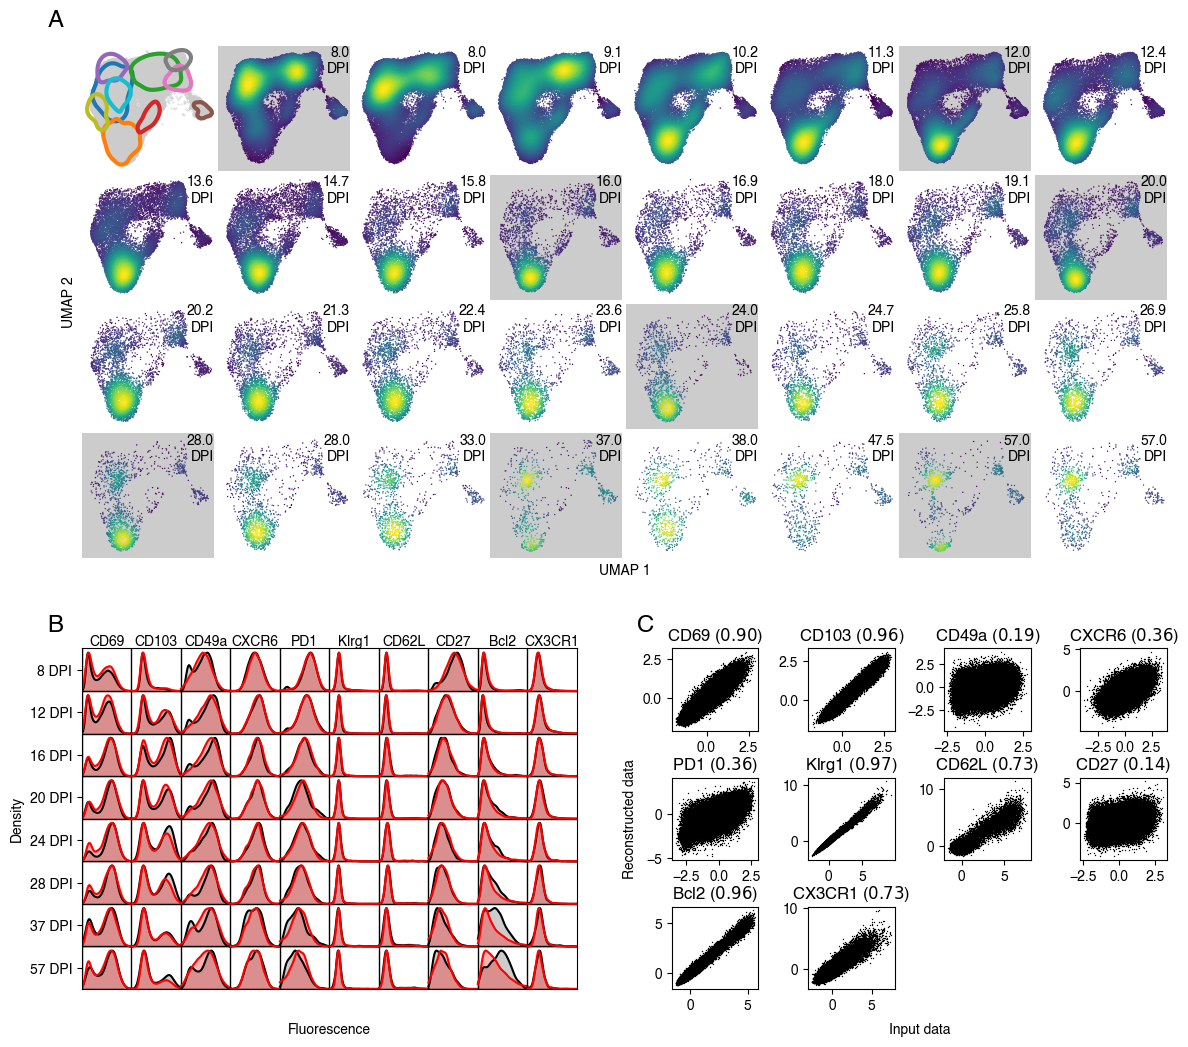

In [7]:
fig

In [8]:
#fig.savefig("../results/FigureIntegratedValidationCD8.pdf", bbox_inches='tight', dpi=200)